# CryptoCoin Project

This project is aimed at predicting the price of a cryptocurrency based on its historical data. We will use the historical data of Bitcoin and Ethereum to train our model and then use it to predict the price of Bitcoin and Ethereum in the future.

# Necessity and Importing Libraries

## Initializing libs and dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import os,glob,sys,time,tqdm

import torch
print(torch.__version__)
import torch.nn as nn
import torch.nn.functional as F

print(f"Pandas version: {pd.__version__}")
print(f"Numpy version: {np.__version__}")
# print(f"Matplotlib version: {plt.__version__}")
print(f"Seaborn version: {sns.__version__}")
print(f"Torch version: {torch.__version__}")
print(f"Python version: {sys.version}")

import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

os.makedirs("results", exist_ok=True)
os.makedirs("images", exist_ok=True)
os.makedirs("models", exist_ok=True)

torch.manual_seed(2025)
# torch.cuda.manual_seed_all(2025)


1.9.1+cpu
Pandas version: 2.2.3
Numpy version: 1.25.0
Seaborn version: 0.13.2
Torch version: 1.9.1+cpu
Python version: 3.9.19 (main, May  6 2024, 20:12:36) [MSC v.1916 64 bit (AMD64)]


## Process Return


In [2]:
import pandas as pd
import numpy as np

def add_returns(df, price_col='price', dt_col='date', method='log'):
    """
    对 DataFrame 中每组资产计算对数收益率或简单收益率，并添加 `return` 列。
    
    参数：
    - df: pandas DataFrame，必须包含 dt_col, price_col, coin_name 四列.
    - price_col: 字段名，价格列，默认为 'price'
    - dt_col: 时间列，默认为 'date'
    - method: 收益率类型，'log' 为对数收益率, 'simple' 为简单收益率
    
    返回：
    - 添加一列 `return` 的 DataFrame，收益率类型根据 method 参数确定。
    """
    df = df.copy()
    # 确保时间排序
    df[dt_col] = pd.to_datetime(df[dt_col])
    df = df.sort_values([ 'coin_name', dt_col ]).reset_index(drop=True)
    
    # 按 coin_name 分组对 price 做 shift
    df['price_prev'] = df.groupby('coin_name')[price_col].shift(1)
    
    if method == 'log':
        df['return'] = np.log(df[price_col] / df['price_prev'])
    elif method == 'simple':
        df['return'] = df[price_col] / df['price_prev'] - 1
    else:
        raise ValueError("method must be 'log' or 'simple'")
    
    # 首条无前值的行设为 NaN（默认行为）
    df.drop(columns=['price_prev'], inplace=True)
    return df



In [3]:

file_path = r"C:\Dataset\CryptoCion Historical Price Prediction\dataset"

csv_files = glob.glob(os.path.join(file_path, "*.csv"))

dataframes = []

for file in csv_files:
    df = pd.read_csv(file)
    df = add_returns(df, method='simple')
# print(df_out)

    dataframes.append(df)

combined_df = pd.concat(dataframes, ignore_index=True)
# 2019-06-21
# combined_df['date'] = pd.to_datetime(combined_df['date'], format='%Y-%m-%d')
# print(combined_df)
print(combined_df.shape)
# combined_df['date'] = combined_df['date'].str.split(' ').str[0]
# combined_df['date'] = pd.to_datetime(combined_df['date'], format='%Y-%m-%d')
print(combined_df.shape)
combined_df.head()


(98828, 6)
(98828, 6)


,date,price,total_volume,market_cap,coin_name,return
0,2019-06-21,1.604939,6.653181e+05,0.000000e+00,algorand,NaN
1,2019-06-22,3.172364,1.790331e+08,1.010855e+08,algorand,0.976626
2,2019-06-23,2.159165,2.588226e+08,7.665618e+07,algorand,-0.319383
3,2019-06-24,1.899598,2.100211e+08,6.647512e+07,algorand,-0.120217
4,2019-06-25,1.409310,1.574706e+08,5.522254e+07,algorand,-0.258101


In [4]:
combined_df.columns

Index(['date', 'price', 'total_volume', 'market_cap', 'coin_name', 'return'], dtype='object')

In [5]:
combined_df.drop(columns=['price', 'total_volume', 'market_cap',], inplace=True)
combined_df.rename(columns={'return': 'price'}, inplace=True)
combined_df.fillna(0, inplace=True)
combined_df.head()

,date,coin_name,price
0,2019-06-21,algorand,0.000000
1,2019-06-22,algorand,0.976626
2,2019-06-23,algorand,-0.319383
3,2019-06-24,algorand,-0.120217
4,2019-06-25,algorand,-0.258101


date : date of observation - the price is taken at 00:00:00 hours

price : Price at the given date and time

total_volume : volume of transactions on the given day

market_cap : Market capitalization in USD


In [7]:
# wide_table = pd.pivot_table(combined_df, index='date', columns='coin_name', values='price')
# corr = wide_table.corr(numeric_only=True)
# plt.figure(figsize=(10, 6))
# ax = sns.heatmap(corr, cmap='YlGnBu', annot=False, linewidths=0,
#                  xticklabels=True, yticklabels=True)
# ax.set_title('Correlation Matrix For Cryptocurrency Prices')
# ax.set_xlabel('Cryptocurrency')
# ax.set_ylabel('Cryptocurrency')
# plt.show()

## Prepare the sample data for analysis

In [8]:
# import matplotlib.pyplot as plt
# import pandas as pd

# # 假设df是你的数据框，包含如下列：
# # coin_name | date_count | price_min | price_max | price_std

# df = pd.read_csv('summary_stat.csv')

# # 计算价格均值和标准差
# df['price_mean'] = (df.price_min + df.price_max) / 2
# df['price_range'] = df.price_max - df.price_min

# # 分离price_max > 1000 和 price_max <= 1000 的数据
# df_high = df[df.price_max > 1000]
# df_low = df[df.price_max <= 1000]

# # 创建两轴布局（上下两个子图）
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), 
#                                gridspec_kw={'height_ratios': [3, 1]})

# # 创建右侧Y轴
# ax1_right = ax1.twinx()

# # 上部分：价格范围与标准差
# # 低价格部分（左侧Y轴）
# ax1.errorbar(range(len(df_low)), 
#              df_low.price_mean,
#              yerr=df_low.price_std,
#              fmt='o',
#              capsize=5,
#              color='#2c7bb6',
#              label='Mean ± STD (price_max <= 1000)')

# # 添加价格区间阴影（min-max）低价格部分
# for i, coin in enumerate(df_low.coin_name):
#     ax1.vlines(i, 
#                df_low.price_min.iloc[i], 
#                df_low.price_max.iloc[i], 
#                color='#2c7bb6', 
#                linewidth=3,
#                alpha=0.5,
#                label='Min-Max Range (price_max <= 1000)' if i==0 else None)

# # 高价格部分（右侧Y轴）
# ax1_right.errorbar(range(len(df_low), len(df_low) + len(df_high)), 
#                    df_high.price_mean,
#                    yerr=df_high.price_std,
#                    fmt='o',
#                    capsize=5,
#                    color='#d7191c',
#                    label='Mean ± STD (price_max > 1000)')

# # 添加价格区间阴影（min-max）高价格部分
# for i, coin in enumerate(df_high.coin_name):
#     ax1_right.vlines(i + len(df_low), 
#                      df_high.price_min.iloc[i], 
#                      df_high.price_max.iloc[i], 
#                      color='#d7191c', 
#                      linewidth=3,
#                      alpha=0.5,
#                      label='Min-Max Range (price_max > 1000)' if i==0 else None)

# # 设置标题和标签
# ax1.set_title('Cryptocurrency Price Distribution', fontsize=14)
# ax1.set_ylabel('Price (USD) - price_max <= 1000', fontsize=12, color='#2c7bb6')
# ax1_right.set_ylabel('Price (USD) - price_max > 1000', fontsize=12, color='#d7191c')

# # 设置X轴标签
# ax1.set_xticks(range(len(df_low) + len(df_high)))
# ax1.set_xticklabels(list(df_low.coin_name) + list(df_high.coin_name), rotation=90)

# # 添加图例
# lines1, labels1 = ax1.get_legend_handles_labels()
# lines2, labels2 = ax1_right.get_legend_handles_labels()
# ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# # 设置网格
# ax1.grid(axis='y', linestyle='--', alpha=0.7)
# ax1_right.grid(axis='y', linestyle='--', alpha=0.7)

# # 下部分：日期计数
# ax2.bar(range(len(df_low)), 
#         df_low.date_count,
#         color='#008837',
#         alpha=0.7,
#         label='Days (price_max <= 1000)')

# ax2.bar(range(len(df_low), len(df_low) + len(df_high)), 
#         df_high.date_count,
#         color='#d7191c',
#         alpha=0.7,
#         label='Days (price_max > 1000)')

# ax2.set_ylabel('Days', fontsize=12)
# ax2.set_xlabel('Trading Days in Total', fontsize=12)
# ax2.legend(loc='upper center')
# ax2.grid(axis='y', linestyle='--', alpha=0.7)

# # 设置X轴标签
# ax2.set_xticks(range(len(df_low) + len(df_high)))
# # ax2.set_xticklabels(list(df_low.coin_name) + list(df_high.coin_name), rotation=90)

# # 显示图表
# plt.tight_layout()
# plt.show()


In [6]:
name_list = combined_df['coin_name'].unique().tolist()
print(name_list)
print(len(name_list))


['algorand', 'apecoin', 'avalanche-2', 'axie-infinity', 'binance-usd', 'binancecoin', 'bitcoin-cash', 'bitcoin', 'cardano', 'chain-2', 'chainlink', 'chiliz', 'cosmos', 'crypto-com-chain', 'dai', 'decentraland', 'dogecoin', 'eos', 'ethereum-classic', 'ethereum', 'filecoin', 'flow', 'frax', 'ftx-token', 'hedera-hashgraph', 'internet-computer', 'leo-token', 'lido-dao', 'litecoin', 'matic-network', 'monero', 'near', 'okb', 'polkadot', 'quant-network', 'ripple', 'shiba-inu', 'solana', 'staked-ether', 'stellar', 'terra-luna', 'tether', 'tezos', 'the-sandbox', 'theta-token', 'tron', 'uniswap', 'usd-coin', 'vechain', 'wrapped-bitcoin']
50


## Pre-EDA for Single One

In [ ]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# df = pd.read_csv(r"C:\Dataset\CryptoCion Historical Price Prediction\dataset\near.csv")
# df

: 

In [ ]:

def plot_crypto_overview(dataset):
    """
    绘制加密货币的价格和交易量走势图
    参数:
        dataset: 包含 'date', 'price', 'total_volume', 'coin_name' 列的 DataFrame
    """
    # 确保 date 是 datetime 类型
    dataset = dataset.copy()
    dataset['date'] = pd.to_datetime(dataset['date'])

    # 设置画布风格
    # plt.style.use('seaborn-darkgrid')
    fig = plt.figure(figsize=(16, 10))
    
    # 上图：价格走势
    top_plt = plt.subplot2grid((5, 4), (0, 0), rowspan=3, colspan=4)
    top_plt.plot(dataset.date, dataset["price"], color='tab:blue', linewidth=2.2, label='Price')
    top_plt.set_title(
        f'Historical Prices of {dataset.coin_name.unique()[0]} \n[{dataset.date.min().date()} to {dataset.date.max().date()}]',
        fontsize=16, fontweight='bold')
    top_plt.set_ylabel('Price (USD)')
    top_plt.legend(loc='upper left')
    
    # 下图：交易量柱状图
    bottom_plt = plt.subplot2grid((5, 4), (3, 0), rowspan=1, colspan=4)
    bottom_plt.bar(dataset.date, dataset['total_volume'], color='tab:orange', width=0.8, label='Trading Volume')
    bottom_plt.set_title('Daily Trading Volume', fontsize=14, y=-0.5)
    bottom_plt.set_ylabel('Volume')
    bottom_plt.legend(loc='upper left')

    # 美化细节
    for ax in [top_plt, bottom_plt]:
        # ax.tick_params(axis='x', labelrotation=45)
        ax.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

# # 示例：生成随机数据测试效果
# def generate_sample_crypto_data(n_days=60, coin_name='Bitcoin'):
#     dates = pd.date_range(end=pd.Timestamp.today(), periods=n_days)
#     prices = np.cumsum(np.random.randn(n_days) * 20 + 30000)  # 模拟价格波动
#     volumes = np.random.randint(1e6, 5e6, size=n_days)        # 模拟交易量
#     return pd.DataFrame({
#         'date': dates,
#         'price': prices,
#         'total_volume': volumes,
#         'coin_name': coin_name
#     })

# 使用演示
# sample_data = generate_sample_crypto_data()
# plot_crypto_overview(df)


In [ ]:
# plt.figure(figsize = (10, 6))
# dataplot = sns.heatmap(sample_data[['price', 'total_volume', 'market_cap']].corr(), cmap="BuPu", annot=True, 
#                       fmt=".1f")
# plt.show()

## Pre-Stationary Analysis & Model Selection

unit root test

- ADF Test
- KPSS Test

plot analysis

- ACF plot
- PACF plot



### ADF(Augmented Dickey Fuller)

ADF test is used to determine the presence of unit root in the series, and hence helps in understand if the series is stationary or not. The null and alternate hypothesis of this test are:

1. Null Hypothesis: The series has a unit root.
2. Alternate Hypothesis: The series has no unit root.

p-value < 0.05: Reject the null hypothesis, the series has a unit root which suggests the series is stationary.

Note: Your ideal result shoud be p-value > 0.05, which means the series is not stationary.


### KPSS(Kwiatkowski Phillips Schmidt Shin)

1. Null Hypothesis: The process is trend stationary.    
2. Alternate Hypothesis: The series has a unit root (series is not stationary).

Your target is No-stationary Results which means you should reject the null hypothesis(p value < 0.05)


In [ ]:
# from statsmodels.tsa.stattools import adfuller
# # result = adfuller(sample_data.price.values, autolag='AIC')
# res1 = adfuller(sample_data.price.values, autolag='AIC')
# res2 = adfuller(sample_data.price.values, autolag='BIC')
# res3 = adfuller(sample_data.price.values, autolag='t-stat')
# print(res1)
# print(res2)
# print(res3)
# # result

In [ ]:

def stationarity_test_summary(
    data: pd.DataFrame,
    column: str,
    coin_name: str = None,
    test_type: str = 'adf'
) -> pd.DataFrame:
    """
    Perform ADF, KPSS, or both stationarity tests on a time series column.

    Parameters:
        data (pd.DataFrame): Input data containing the time series.
        column (str): Name of the time series column to test.
        coin_name (str): Optional filter value for 'coin_name'.
        test_type (str): 'adf', 'kpss', or 'both'.

    Returns:
        pd.DataFrame: Test results.
    """
    if test_type not in ['adf', 'kpss', 'both']:
        raise ValueError("test_type must be 'adf', 'kpss', or 'both'.")

    results = []

    if coin_name is not None:
        data = data[data['coin_name'] == coin_name].copy()

    data = data[[column]].dropna()

    def run_test(method, test_type_local):
        if test_type_local == 'adf':
            res = adfuller(data[column].values, autolag=method)
            stat, pvalue, usedlag, nobs = res[0], res[1], res[2], res[3]
            decision = 'Stationary' if pvalue < 0.05 else 'Not Stationary'
        elif test_type_local == 'kpss':
            res = kpss(data[column].values, regression=method, nlags='auto')
            stat, pvalue, usedlag, nobs = res[0], res[1], res[2], len(data)
            decision = 'Stationary' if pvalue > 0.05 else 'Not Stationary'
        return {
            'Test': test_type_local.upper(),
            'Method': method,
            'Coin Name': coin_name if coin_name else 'ALL',
            'Statistic': f"{stat:.4f}",
            'p-value': f"{pvalue:.4f}",
            'Used Lag': usedlag,
            'Nobs': nobs,
            'Significance(0.05)': decision
        }

    if test_type in ['adf', 'both']:
        for method in ['AIC', 'BIC', 't-stat']:
            results.append(run_test(method, 'adf'))

    if test_type in ['kpss', 'both']:
        for method in ['c', 'ct']:
            results.append(run_test(method, 'kpss'))

    return pd.DataFrame(results)
# summary_both = stationarity_test_summary(sample_data, column='price', coin_name=name_list[0], test_type='both')
# summary_both

### Choosing the right model based on ACF and PACF Plots

| Model Type    | ACF Behavior             | PACF Behavior            |
| ------------- | ------------------------ | ------------------------ |
| **AR(p)**     | Tails off slowly         | **Cuts off after lag p** |
| **MA(q)**     | **Cuts off after lag q** | Tails off slowly         |
| **ARMA(p,q)** | Tails off slowly         | Tails off slowly         |

Then, a sample code is shown as below:


# Conduct Cross Crypto Coin Analysis

Whether they are related to each other?

**This is still EDA for future analysis**

In [8]:
# df1 = combined_df.drop(columns=['total_volume', 'market_cap'])
# # df1.head()
# df_wide = df1.pivot_table(index='date', columns='coin_name', values='price')
# df_wide.head()

In [9]:

# plt.figure(figsize = (10, 6))
# dataplot = sns.heatmap(df_wide.corr(), cmap="BuPu", annot=False, linewidths=0, 
#                       fmt=".1f")
# plt.show()

In [10]:
# df_wide.describe().T

# Model Introduction

For time Series Forecasting, we use some classic models:

- ARIMA (Autoregressive Integrated Moving Average)
- MLP (Multi-Layer Perceptron)
- RNN (Recurrent Neural Network)
- CNN(Convolutional Neural Network)
- LSTM (Long Short-Term Memory)
- Bi-LSTM (Bidirectional LSTM)




## ARIMA

Decomposed into:
- AR(p) - Auto-Regressive Model
- MA(q) - Moving Average Model

The ARIMA model is a combination of the AR and MA models. It is used to forecast future values of a time series based on its past values. The ARIMA model is a statistical method that can be used to identify the underlying structure of a time series and make predictions. It is widely used in finance, economics, and other fields where time series data is available.

Formula for AR(p):
$$
Y_t = \alpha + \epsilon_1 + \sum_{i=1}^p \beta_i \times Y_{t-i} 
$$

Formula for MA(q):
$$
Y_t = \alpha + \epsilon_t  + \sum_{i=1}^q \phi_i \times \epsilon_{t-i}
$$

An ARIMA model is one where the time series was differenced at least once to make it stationary and you combine the AR and the MA terms. So the equation becomes:

$$
Y_t = \alpha  + \sum_{i=1}^p \beta_i \times Y_{t-i} + \sum_{j=1}^q \phi_j \times \epsilon_{t-j}
$$

Predicted Yt = Constant + Linear combination Lags of Y (upto p lags) + Linear Combination of Lagged forecast errors (upto q lags)

In [11]:
# fig, axes = plt.subplots(3, 2, sharex=True)
# axes[0, 0].plot(sample_data.price.values); axes[0, 0].set_title('Original Series')
# plot_acf(sample_data.price.values, ax=axes[0, 1])

# # 1st Differencing
# axes[1, 0].plot(sample_data.price.diff()); axes[1, 0].set_title('1st Order Differencing')
# plot_acf(sample_data.price.diff().dropna(), ax=axes[1, 1])

# # 2nd Differencing
# axes[2, 0].plot(sample_data.price.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
# plot_acf(sample_data.price.diff().diff().dropna(), ax=axes[2, 1])

# plt.show()

In [12]:
# plot_acf(sample_data.price.values, lags=40)
# plot_pacf(sample_data.price.values, lags=40)

In [13]:
# !pip install pmdarima

In [14]:
# data = sample_data.price.values
# print(data.shape)

# train_length = int(len(data) * 0.8)
# print('Train length: ', train_length)

# train_data, test_data = data[:train_length], data[train_length:]
# print('Shape of Train and Test data: ', len(train_data), len(test_data))

In [6]:

from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

def arima_prediction(train_data, test_data,coin_name):

    auto_model = auto_arima(train_data, seasonal=False, stepwise=True, random_state=2025)
    auto_params = auto_model.get_params()
    # print(auto_params)

    model = ARIMA(train_data, order=auto_params['order'])
    model_fit = model.fit()

    test_data_pred = model_fit.forecast(len(test_data))

    df = pd.DataFrame({'Actual': test_data, 'Predicted': test_data_pred})

    df.to_csv(os.path.join(f"coin_results/{coin_name}", "ARIMA_predictions.csv"), index=False)
    
    plt.plot(test_data, '#0077be',label = 'Actual')
    plt.plot(test_data_pred, '#ff8841',label = 'Predicted')
    plt.title(f'ARIMA Model for Price Forecasting of {coin_name}')
    plt.ylabel('Price [in Dollar]')
    plt.xlabel('Time Steps [in Days] ')
    plt.legend()
    plt.savefig(os.path.join(f"coin_images/{coin_name}", "ARIMA_predictions.png"))
    # plt.show()
    plt.close()
    

# arima_prediction(train_data= train_data,test_data=test_data)


In [16]:

# from pmdarima import auto_arima
# from statsmodels.tsa.arima.model import ARIMA
# auto_model = auto_arima(sample_data.price.values, seasonal=False, stepwise=True,random_state= 2025)
# # auto_model.summary()
# auto_params = auto_model.get_params()
# print(auto_params)
# model = ARIMA(sample_data.price.values, order=(auto_params['order']))
# model_fit = model.fit()
# sample_data_pred = model_fit.predict(n_periods=150)
# df = pd.DataFrame({'Actual': sample_data.price.values, 'Predict': sample_data_pred})
# df.to_csv(os.path.join("results", "ARIMA_predictions.csv"),index=False)


In [17]:
# print(model_fit.summary())

Note:

Ljung-Box test should be less than 0.05 to reject the null hypothesis of white noise.

## MLP


### Split the Sequence


In [7]:
# data = sample_data.price.values
# print(data.shape)

# train_length = int(len(data) * 0.8)
# print('Train length: ', train_length)

# train_data, test_data = data[:train_length], data[train_length:]
# print('Shape of Train and Test data: ', len(train_data), len(test_data))

In [8]:
# from statsmodels.tsa.stattools import pacf
# pacf_value = pacf(sample_data.price.values, nlags=20)
# lag = 0
# # collect lag values greater than 10% correlation 
# for x in pacf_value:
#     if x > 0.1:
#         lag += 1
#     else:
#         break
# print('Selected look_back (or lag = ): ', lag)

### Window Selection

滑动窗口法 (Sliding Window): 通过一个固定大小的窗口不断在时间序列上滑动，生成多个训练和测试集。例如，使用最近5天的数据来预测第6天的值，然后窗口向前滑动一天，重复此过程。这允许模型在每次迭代中使用最新的数据进行训练

扩展窗口法 (Expanding Window): 与滑动窗口法不同，训练集的大小会随着时间的推移而增加。每次迭代都使用之前的所有数据，从而提供更丰富的信息来进行预测。这种方法适合于需要保持历史信息完整性的情境


In [9]:

# from numpy import array
# def split_sequence(sequence, n_steps):
#     X, y = list(), list()
#     for i in range(len(sequence)):
#         end_ix = i + n_steps
#         if end_ix > len(sequence)-1:
#             break
#         seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
#         X.append(seq_x)
#         y.append(seq_y)
#     return array(X), array(y)

# train_X, train_y = split_sequence(train_data, lag)
# test_X, test_y = split_sequence(test_data, lag)
# print(train_X[:3])
# print(train_y[:3])
# # train_X = torch.tensor(train_X, dtype=torch.float32)
# # train_y = torch.tensor(train_y, dtype=torch.float32)
# # test_X = torch.tensor(test_X, dtype=torch.float32)
# # test_y = torch.tensor(test_y, dtype=torch.float32)
# # print(train_X[:3])
# # train_X = train_X.unsqueeze(-1)
# # test_X = test_X.unsqueeze(-1)
# # print(train_X[:3])
# print('Shape of train_X and train_y:', train_X.shape, train_y.shape)
# print('Shape of test_X and test_y:', test_X.shape, test_y.shape)


In [10]:
# for x in range(len(train_X[:20])):
#     print(test_X[x], test_y[x], )

### Toolkit

In [11]:

from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm



#### Tuning


In [12]:
# ===============================
# 4. 超参数调优
# ===============================

def hyperparameter_tuning(coin_model,train_X, train_y, val_X, val_y, input_dim):
    # 定义待选超参数
    activation_list = ["relu", "elu", "sigmoid", "tanh"]
    optimizer_list  = ["adam", "sgd", "rmsprop"]
    epochs_list     = [10, 20, 40, 80, 160]
    batchsize_list  = [8, 16, 32, 64, 128]
    
    # 存储最佳参数
    best_params = {}
    
    # 6.1 选择最佳激活函数
    # print("\nTuning Activation Functions...")
    sel_activation = {}
    for act in activation_list:
        history, model = coin_model(train_X, train_y, val_X, val_y,
                                 input_dim=input_dim,
                                 activation=act,
                                 optimizer_name="adam",
                                 epochs=5,
                                 batch_size=16)
        sel_activation[act] = history["val_loss"][-1]
        del model
    best_activation = min(sel_activation, key=sel_activation.get)
    best_params['activation'] = best_activation
    # print(f"Best Activation: {best_activation}")
    
    # 6.2 选择最佳优化器
    # print("\nTuning Optimizers...")
    sel_optimizer = {}
    for opt in optimizer_list:
        history, model = coin_model(train_X, train_y, val_X, val_y,
                                 input_dim=input_dim,
                                 activation=best_activation,
                                 optimizer_name=opt,
                                 epochs=5,
                                 batch_size=16)
        sel_optimizer[opt] = history["val_loss"][-1]
        del model
    best_optimizer = min(sel_optimizer, key=sel_optimizer.get)
    best_params['optimizer'] = best_optimizer
    # print(f"Best Optimizer: {best_optimizer}")
    
    # 6.3 选择最佳训练轮数
    # print("\nTuning Epochs...")
    loss_val_epoch = {}
    for ep in epochs_list:
        history, model = coin_model(train_X, train_y, val_X, val_y,
                                 input_dim=input_dim,
                                 activation=best_activation,
                                 optimizer_name=best_optimizer,
                                 epochs=ep,
                                 batch_size=16)
        loss_val_epoch[ep] = history["val_loss"][-1]
        del model
    best_epoch = min(loss_val_epoch, key=loss_val_epoch.get)
    best_params['epochs'] = best_epoch
    # print(f"Best Epochs: {best_epoch}")
    
    # 6.4 选择最佳批量大小
    # print("\nTuning Batch Sizes...")
    loss_val_batch = {}
    for bs in batchsize_list:
        history, model = coin_model(train_X, train_y, val_X, val_y,
                                 input_dim=input_dim,
                                 activation=best_activation,
                                 optimizer_name=best_optimizer,
                                 epochs=best_epoch,
                                 batch_size=bs)
        loss_val_batch[bs] = history["val_loss"][-1]
        del model
    best_batch = min(loss_val_batch, key=loss_val_batch.get)
    best_params['batch_size'] = best_batch
    # print(f"Best Batch Size: {best_batch}")
    
    return best_params


#### Plot

In [7]:

# ===============================
# 5. 可视化工具
# ===============================
def plot_training_history(history,name,coin_name):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss Evolution')
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_rmse'], label='Train RMSE')
    plt.plot(history['val_rmse'], label='Validation RMSE')
    plt.title(f'RMSE Evolution for {coin_name.upper()} with {name.upper()}')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.legend()
    
    plt.tight_layout()
    os.makedirs("coin_images", exist_ok=True)
    plt.savefig(os.path.join(f"coin_images/{coin_name}", f"{name.upper()}_training_metrics.png"))
    plt.close()


#### Evaluate

In [14]:

# ===============================
# 6. 最终评估
# ===============================
def evaluate_model(coin_model, test_X, test_y, batch_size,name,coin_name):
    test_dataset = TensorDataset(test_X, test_y)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,drop_last=True)
    
    device = next(coin_model.parameters()).device
    coin_model.eval()
    
    test_loss = 0.0
    test_rmse = 0.0
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = coin_model(batch_X)
            
            # 存储预测结果
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(batch_y.cpu().numpy())
            
            # 计算指标
            loss = F.mse_loss(outputs, batch_y)
            test_loss += loss.item() * batch_X.size(0)
            test_rmse += torch.sqrt(loss).item() * batch_X.size(0)
    # predictions = np.array(predictions)
    out_df = pd.DataFrame({'Actual': actuals, 'Predicted': predictions})
    out_df.to_csv(os.path.join(f"coin_results/{coin_name}", f"{name.upper()}_predictions.csv"), index=False)
    # print(f"Prediction shape is {out_df.shape}")
    test_loss /= len(test_loader.dataset)
    test_rmse /= len(test_loader.dataset)
    
    # 绘制预测结果
    plt.figure(figsize=(10, 6))
    plt.plot(actuals, label='Actual Values', alpha=0.7)
    plt.plot(predictions, label='Predictions', linestyle='--', alpha=0.7)
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.legend()
    plt.savefig(os.path.join("images", f"{name.upper()}_predictions.png"), dpi=300)
    
    return {
        'test_loss': test_loss,
        'test_rmse': test_rmse,
        'predictions': np.array(predictions),
        'actuals': np.array(actuals)
    }

#### Main

In [15]:
# ===============================
# 主程序流程
# ===============================
from torchsummary import summary

def crypto_coin_main(coin_model, train_data, test_data, lag,name,coin_name,add_dimension=False,):

    # 数据预处理
    train_X, train_y = split_sequence(train_data, lag)
    test_X, test_y = split_sequence(test_data, lag)
    
    # 转换为张量
    train_X = torch.tensor(train_X, dtype=torch.float32)
    train_y = torch.tensor(train_y, dtype=torch.float32)
    test_X = torch.tensor(test_X, dtype=torch.float32)
    test_y = torch.tensor(test_y, dtype=torch.float32)
    
    # 划分验证集（取训练集的后20%）
    val_size = int(len(train_X) * 0.2)
    val_X, val_y = train_X[-val_size:], train_y[-val_size:]
    train_X, train_y = train_X[:-val_size], train_y[:-val_size]
    
    if add_dimension:
        train_X = train_X.unsqueeze(-1)
        test_X = test_X.unsqueeze(-1)
        val_X = val_X.unsqueeze(-1)
    
    # print(f"Training Set: {len(train_X)} samples")
    # print(f"Validation Set: {len(val_X)} samples")
    # print(f"Test Set: {len(test_X)} samples")
    
    # 超参数调优
    best_params = hyperparameter_tuning(coin_model, train_X, train_y, val_X, val_y, input_dim=lag)
    # print("\nFinal Best Parameters:")
    # print(best_params)
    
    # 训练最终模型
    final_history, best_model = coin_model(
        torch.cat([train_X, val_X]),  # 使用全部可用数据
        torch.cat([train_y, val_y]),
        val_X,  # 验证集可以复用
        val_y,
        input_dim=lag,
        activation=best_params['activation'],
        optimizer_name=best_params['optimizer'],
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size']
    )
    
    # 可视化训练过程
    plot_training_history(final_history,name,coin_name=coin_name)
    
    # 最终评估
    results = evaluate_model(best_model, test_X, test_y, 
                            batch_size=best_params['batch_size'],name=name,coin_name=coin_name)
    
    # print("\nFinal Test Performance:")
    # print(f"MSE Loss: {results['test_loss']:.4f}")
    # print(f"RMSE: {results['test_rmse']:.4f}")
    
    # 保存模型
    # torch.save(best_model.state_dict(), os.path.join("models", f'best_{name.upper()}_model.pth'))
    # print("\nModel saved to best_model.pth")
    
    # try:
    #     if add_dimension:
    #         summary(best_model,input_size=(2,1,))
    #     else:
    #         summary(best_model,input_size=(2,))
    # except:
    #     pass

### MLP

In [16]:


# ===============================
# 2. 模型定义
# ===============================
class MLPRegressor(nn.Module):
    def __init__(self, input_dim, activation_func="relu"):
        super(MLPRegressor, self).__init__()
        # 激活函数选择
        if activation_func == "relu":
            self.act = F.relu
        elif activation_func == "elu":
            self.act = F.elu
        elif activation_func == "sigmoid":
            self.act = torch.sigmoid
        elif activation_func == "tanh":
            self.act = torch.tanh
        else:
            self.act = F.relu

        # 模型结构
        self.fc1 = nn.Linear(input_dim, 32)
        self.bn1 = nn.BatchNorm1d(32)
        self.dropout1 = nn.Dropout(0.2)

        self.fc2 = nn.Linear(32, 16)
        self.bn2 = nn.BatchNorm1d(16)
        self.dropout2 = nn.Dropout(0.2)

        self.fc3 = nn.Linear(16, 1)  # 输出连续值

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.bn1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.act(x)
        x = self.bn2(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        return x.squeeze()  # 压缩输出维度

# ===============================
# 3. 训练函数
# ===============================
def mlp_coin(train_X, train_y, val_X, val_y, input_dim, 
            activation="relu", optimizer_name="adam", 
            epochs=10, batch_size=32):
    # 创建模型实例
    model = MLPRegressor(input_dim=input_dim, activation_func=activation)
    
    # 选择优化器
    if optimizer_name.lower() == "adam":
        optimizer = torch.optim.Adam(model.parameters())
    elif optimizer_name.lower() == "sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    elif optimizer_name.lower() == "rmsprop":
        optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01)
    else:
        optimizer = torch.optim.Adam(model.parameters())
    
    # 损失函数
    criterion = nn.MSELoss()
    
    # 构建 DataLoader
    train_dataset = TensorDataset(train_X, train_y)
    val_dataset = TensorDataset(val_X, val_y)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,drop_last=True)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    history = {"train_loss": [], "val_loss": [], 
               "train_rmse": [], "val_rmse": []}
    
    for epoch in range(epochs):
        # 训练阶段
        model.train()
        train_loss = 0.0
        train_rmse = 0.0
        for batch_X, batch_y in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}",leave=False):
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * batch_X.size(0)
            rmse = torch.sqrt(loss)
            train_rmse += rmse.item() * batch_X.size(0)
            
        train_loss /= len(train_loader.dataset)
        train_rmse /= len(train_loader.dataset)
        history["train_loss"].append(train_loss)
        history["train_rmse"].append(train_rmse)
        
        # 验证阶段
        model.eval()
        val_loss = 0.0
        val_rmse = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                
                val_loss += loss.item() * batch_X.size(0)
                rmse = torch.sqrt(loss)
                val_rmse += rmse.item() * batch_X.size(0)
                
        val_loss /= len(val_loader.dataset)
        val_rmse /= len(val_loader.dataset)
        history["val_loss"].append(val_loss)
        history["val_rmse"].append(val_rmse)
        
        # print(f"Epoch {epoch+1}/{epochs}: "
        #       f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
        #       f"Train RMSE: {train_rmse:.4f} | Val RMSE: {val_rmse:.4f}")
    
    return history, model


# crypto_coin_main(mlp_coin,train_data,test_data,lag=lag,name='mlp',add_dimension=False)

## RNN

In [17]:
# ===============================
# 2. RNN模型定义
# ===============================
class RNNRegressor(nn.Module):
    def __init__(self, input_dim, hidden_size=64, num_layers=1):
        super(RNNRegressor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.rnn = nn.RNN(
            # input_size=input_dim,
            input_size=1,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            nonlinearity='tanh'
        )
        self.fc = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # 初始化隐藏状态
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # RNN前向传播
        out, _ = self.rnn(x, h0)
        
        # 取最后一个时间步并添加正则化
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out.squeeze()

# ===============================
# 3. 训练函数（修改为RNN版本）
# ===============================
def rnn_coin(train_X, train_y, val_X, val_y, input_dim, 
            activation="tanh", optimizer_name="adam", 
            epochs=10, batch_size=32):
    
    # 确保输入数据为三维张量 (batch, seq_len, features)
    if train_X.ndim == 2:
        train_X = train_X.unsqueeze(-1)
        val_X = val_X.unsqueeze(-1)
    
    model = RNNRegressor(input_dim=input_dim)
    # 选择优化器
    if optimizer_name.lower() == "adam":
        optimizer = torch.optim.Adam(model.parameters())
    elif optimizer_name.lower() == "sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    elif optimizer_name.lower() == "rmsprop":
        optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01)
    else:
        optimizer = torch.optim.Adam(model.parameters())    
    # 优化器选择（保持原结构）
    # optimizer_dict = {
    #     "adam": torch.optim.Adam,
    #     "sgd": torch.optim.SGD,
    #     "rmsprop": torch.optim.RMSprop
    # }
    # optimizer = optimizer_dict.get(optimizer_name.lower(), torch.optim.Adam)(model.parameters())
    
    criterion = nn.MSELoss()
    
    # 数据加载器（保持原结构）
    train_dataset = TensorDataset(train_X, train_y)
    val_dataset = TensorDataset(val_X, val_y)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # 训练逻辑（保持原结构）
    history = {"train_loss": [], "val_loss": [], "train_rmse": [], "val_rmse": []}
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_rmse = 0.0
        for batch_X, batch_y in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}", leave=False):
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * batch_X.size(0)
            train_rmse += torch.sqrt(loss).item() * batch_X.size(0)
        
        # 验证逻辑（保持原结构）
        model.eval()
        val_loss = 0.0
        val_rmse = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item() * batch_X.size(0)
                val_rmse += torch.sqrt(loss).item() * batch_X.size(0)
        
        # 统计计算（保持原结构）
        train_loss /= len(train_loader.dataset)
        train_rmse /= len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)
        val_rmse /= len(val_loader.dataset)
        
        history["train_loss"].append(train_loss)
        history["train_rmse"].append(train_rmse)
        history["val_loss"].append(val_loss)
        history["val_rmse"].append(val_rmse)
    
    return history, model

# crypto_coin_main(rnn_coin,train_data,test_data,lag=lag,name='rnn',add_dimension=True)
    
    

## LSTM

In [18]:
# ===============================
# 2. LSTM模型定义
# ===============================
class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_size=64, num_layers=1):
        super(LSTMRegressor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            # input_size=input_dim,
            input_size=1,  # 修改为1
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # 初始化隐藏状态和细胞状态
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # LSTM前向传播
        out, _ = self.lstm(x, (h0, c0))
        
        # 取最后一个时间步并添加正则化
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out.squeeze()

# ===============================
# 3. 训练函数（修改为LSTM版本）
# ===============================
def lstm_coin(train_X, train_y, val_X, val_y, input_dim, 
            activation="tanh", optimizer_name="adam", 
            epochs=10, batch_size=32):
    
    # 确保输入数据为三维张量 (batch, seq_len, features)
    if train_X.ndim == 2:
        train_X = train_X.unsqueeze(-1)
        val_X = val_X.unsqueeze(-1)
    
    model = LSTMRegressor(input_dim=input_dim)  # 修改为LSTM模型
    # 选择优化器
    if optimizer_name.lower() == "adam":
        optimizer = torch.optim.Adam(model.parameters())
    elif optimizer_name.lower() == "sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    elif optimizer_name.lower() == "rmsprop":
        optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01)
    else:
        optimizer = torch.optim.Adam(model.parameters())    
    # # 优化器选择（保持原结构）
    # optimizer_dict = {
    #     "adam": torch.optim.Adam,
    #     "sgd": torch.optim.SGD,
    #     "rmsprop": torch.optim.RMSprop
    # }
    # optimizer = optimizer_dict.get(optimizer_name.lower(), torch.optim.Adam)(model.parameters())
    
    criterion = nn.MSELoss()
    
    # 数据加载器（保持原结构）
    train_dataset = TensorDataset(train_X, train_y)
    val_dataset = TensorDataset(val_X, val_y)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # 训练逻辑（保持原结构）
    history = {"train_loss": [], "val_loss": [], "train_rmse": [], "val_rmse": []}
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_rmse = 0.0
        for batch_X, batch_y in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}", leave=False):
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * batch_X.size(0)
            train_rmse += torch.sqrt(loss).item() * batch_X.size(0)
        
        # 验证逻辑（保持原结构）
        model.eval()
        val_loss = 0.0
        val_rmse = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item() * batch_X.size(0)
                val_rmse += torch.sqrt(loss).item() * batch_X.size(0)
        
        # 统计计算（保持原结构）
        train_loss /= len(train_loader.dataset)
        train_rmse /= len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)
        val_rmse /= len(val_loader.dataset)
        
        history["train_loss"].append(train_loss)
        history["train_rmse"].append(train_rmse)
        history["val_loss"].append(val_loss)
        history["val_rmse"].append(val_rmse)
    
    return history, model

# crypto_coin_main(lstm_coin,train_data,test_data,lag=lag,name='lstm',add_dimension=True)


## Bi-LSTM

In [19]:
# ===============================
# 2. BiLSTM模型定义
# ===============================
class BiLSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_size=64, num_layers=1):
        super(BiLSTMRegressor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            # input_size=input_dim,
            input_size=1,  # 输入维度为1
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True  # 添加双向参数
        )
        self.fc = nn.Linear(hidden_size * 2, 1)  # 输入维度翻倍
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # 初始化双向隐藏状态和细胞状态（层数×2）
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size).to(x.device)
        
        # BiLSTM前向传播
        out, _ = self.lstm(x, (h0, c0))
        
        # 拼接最后时间步的正反向输出
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out.squeeze()

# ===============================
# 3. 训练函数（修改为BiLSTM版本）
# ===============================
def bilstm_coin(train_X, train_y, val_X, val_y, input_dim, 
               activation="tanh", optimizer_name="adam", 
               epochs=10, batch_size=32):
    
    # 确保输入数据为三维张量 (batch, seq_len, features)
    if train_X.ndim == 2:
        train_X = train_X.unsqueeze(-1)
        val_X = val_X.unsqueeze(-1)
    
    model = BiLSTMRegressor(input_dim=input_dim)
    
    if optimizer_name.lower() == "adam":
        optimizer = torch.optim.Adam(model.parameters())
    elif optimizer_name.lower() == "sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    elif optimizer_name.lower() == "rmsprop":
        optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01)
    else:
        optimizer = torch.optim.Adam(model.parameters())    
    # # 优化器选择（保持原结构）
    # optimizer_dict = {
    #     "adam": torch.optim.Adam,
    #     "sgd": torch.optim.SGD,
    #     "rmsprop": torch.optim.RMSprop
    # }
    # optimizer = optimizer_dict.get(optimizer_name.lower(), torch.optim.Adam)(model.parameters())
    
    criterion = nn.MSELoss()
    
    # 数据加载器（保持原结构）
    train_dataset = TensorDataset(train_X, train_y)
    val_dataset = TensorDataset(val_X, val_y)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # 训练逻辑（保持原结构）
    history = {"train_loss": [], "val_loss": [], "train_rmse": [], "val_rmse": []}
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_rmse = 0.0
        for batch_X, batch_y in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}", leave=False):
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * batch_X.size(0)
            train_rmse += torch.sqrt(loss).item() * batch_X.size(0)
        
        # 验证逻辑
        model.eval()
        val_loss = 0.0
        val_rmse = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item() * batch_X.size(0)
                val_rmse += torch.sqrt(loss).item() * batch_X.size(0)
        
        # 统计计算
        train_loss /= len(train_loader.dataset)
        train_rmse /= len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)
        val_rmse /= len(val_loader.dataset)
        
        history["train_loss"].append(train_loss)
        history["train_rmse"].append(train_rmse)
        history["val_loss"].append(val_loss)
        history["val_rmse"].append(val_rmse)
    
    return history, model

# crypto_coin_main(bilstm_coin,train_data,test_data,lag=lag,name='bilstm',add_dimension=True)



# Evaluation Metrics

Most widely used evaluation metrics for forecasting are:

- F1 Score
  - Precision
  - Recall
- R-squared

Formulas for F1 Score:

- F1 Score = 2 * (Precision * Recall) / (Precision + Recall)
- Precision = TP / (TP + FP)
- Recall = TP / (TP + FN)

R-squared:

R-squared = 1- (SSres / SStot)



## Metrics for Model Evaluation

In [20]:
import math
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error as mae

# 其他代码保持不变
def stat_evaluate_model(actual, predicted,method_name, print_res=False):
    if print_res:
        print('R-squared: ', round(r2_score(actual, predicted), 4))
        print('MAE : ', round(mae(actual, predicted), 4))
        print('MSE: ', round(mean_squared_error(actual, predicted), 4))
        print('RMSE: ', round(math.sqrt(mean_squared_error(actual, predicted)), 4))
        print('NRMSE: ', NRMSE(actual, predicted))
        print('WMAPE: ', WMAPE(actual, predicted))

    res = pd.DataFrame({
        'Model': [method_name],
        'R-squared': [round(r2_score(actual, predicted), 4)],
        'MAE': [round(mae(actual, predicted), 4)],
        'MSE': [round(mean_squared_error(actual, predicted), 4)],
        'RMSE': [round(math.sqrt(mean_squared_error(actual, predicted)), 4)],
        'NRMSE': [NRMSE(actual, predicted)],
        'WMAPE': [WMAPE(actual, predicted)]
    })
    return res

def NRMSE(actual, predicted):
    rmse = math.sqrt(mean_squared_error(actual, predicted))
    nrmse = rmse / np.mean(actual)
    return round(nrmse, 4)

def WMAPE(actual, predicted):
    abs_error = np.sum(np.abs(actual - predicted))
    wmape = abs_error / np.sum(actual)
    return round(wmape, 4)


In [21]:

def evaluate_models(path,coin_name):
    model_list = ['ARIMA', 'MLP', 'RNN', 'LSTM', 'BILSTM']
    combined_df = pd.DataFrame()
    
    for model_name in model_list:
        file_path = rf'{path}\{model_name}_predictions.csv'
        df = pd.read_csv(file_path)
        res = stat_evaluate_model(df['Actual'].values, df['Predicted'].values, model_name, print_res=False)
        res_df = pd.DataFrame(res)  # 将评估结果转换为DataFrame
        res_df['Coin'] = coin_name  # 直接在评估结果的DataFrame中添加'Coin'列
        res_df['Model'] = model_name  # 直接在评估结果的DataFrame中添加'Model'列
        combined_df = pd.concat([combined_df, res_df], axis=0)  # 垂直拼接
    
    return combined_df

# path = os.path.join('results')
# result_df = evaluate_models(path,coin_name=name_list[0])
# print(result_df)


## Metrics for Performance Evaluation

Metrics for Financial Analysis:

- Avg. Return
- Total Return
- MDD: Maximum Drawdown
- F1 Score
  - Precision
  - Recall 
  - $$F1\_score = \frac{(1 + \beta^2) \times (precision \times recall)}{\beta^2 \times precision + recall}$$

- Sharpe Ratio
- Win Ratio

Input should contains:
- df: predicted values
- df: actual values

Output should contains:
- Id: Name of the coin(We will use a loop to conduct this,we have a list of coins )
- Performance Metrics: Avg. Return, Total Return, MDD, F1 Score, Sharpe Ratio, Win Ratio
- which should be formatted in a table

Possible Path for You:

denote increase or decrease for F1 Score

return should be referred to previous homework


In [5]:
"""Generate Signals"""
import numpy as np
import matplotlib.pyplot as plt

def signal_generation(df, actual_col, predicted_col, threshold=0.01, plot=False,ret = False):
    df = df.copy()
    next_pred = df[predicted_col].shift(-1)

    # Generate trading signals based on predicted price movement
    if ret:
        df["signal"] = np.where(
            next_pred > threshold, 1,
            np.where(next_pred < -threshold, -1, 0)
        )
    else:
        df["signal"] = np.where(
            next_pred > df[actual_col] * (1 + threshold), 1,
            np.where(next_pred < df[actual_col] * (1 - threshold), -1, 0)
        )
    # Set last signal to -1 (sell to close position)
    df.loc[df.index[-1], "signal"] = -1

    # print("Signal distribution:")
    # print(df["signal"].value_counts())

    # Generate labels based on actual price movement (for classification)
    df["label"] = np.where(
        df[actual_col].shift(-1) > df[actual_col] * (1 + threshold), 1,
        np.where(df[actual_col].shift(-1) < df[actual_col] * (1 - threshold), -1, 0)
    )

    # print("Label distribution:")
    # print(df["label"].value_counts())

    # Plot if requested
    if plot:
        df["date"] = df.index+1
        plt.figure(figsize=(14, 6))
        plt.plot(df["date"], df[actual_col], label="Actual Price", color='blue')
        plt.plot(df["date"], df[predicted_col], label="Predicted Price", color='orange')
        
        # Buy signals (green upward triangle)
        buy_signals = df["signal"] == 1
        plt.scatter(df.loc[buy_signals, "date"], df.loc[buy_signals, actual_col],
                    label="Buy Signal", marker="^", color="green")

        # Sell signals (red downward triangle)
        sell_signals = df["signal"] == -1
        plt.scatter(df.loc[sell_signals, "date"], df.loc[sell_signals, actual_col],
                    label="Sell Signal", marker="v", color="red")

        plt.title("Price with Trading Signals")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return df

# df = pd.read_csv(r"C:\Software\.minecraft\LSTM_predictions.csv")
# signed_df = signal_generation(df, "Actual", "Predicted",plot=True)
# signed_df.tail()


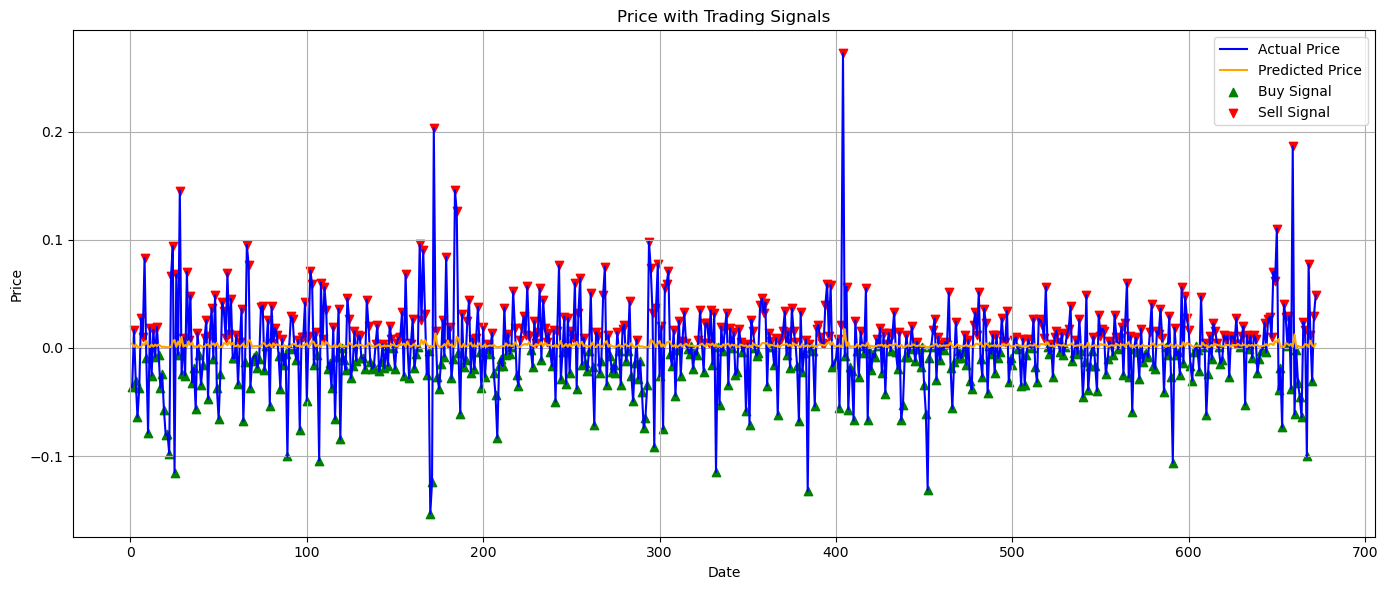

,Actual,Predicted,signal,label,date
0,-0.036049,0.003765,1,1,1
1,0.016750,0.000922,-1,-1,2
2,-0.030282,0.003051,1,-1,3
3,-0.064203,0.001028,1,1,4
4,-0.037389,0.000691,1,1,5
...,...,...,...,...,...
667,0.077634,0.000810,-1,-1,668
668,0.011933,0.006427,-1,-1,669
669,-0.030824,0.002777,1,1,670
670,0.029640,0.001017,-1,1,671


In [ ]:
# import pandas as pd
# C:\Users\Fisher Man\OneDrive\Desktop\Work Sheet\Py\Some Projects\Comput_Fin\Project\coin_images\litecoin\BILSTM_training_metrics.png
# df = pd.read_csv(r"C:\Users\Fisher Man\OneDrive\Desktop\Work Sheet\Py\Some Projects\Comput_Fin\Project\coin_results\litecoin\MLP_predictions.csv")
# signal_generation(df, "Actual", "Predicted",threshold=0.001,plot=True)
# df

In [24]:
def simulate_trading(prices, signals):
    """
    Simulate trading and compute performance metrics based on price and signal sequences.
    
    Args:
        prices (np.array): Price sequence
        signals (np.array): Signal sequence (1 for buy, -1 for sell)
        
    Returns:
        dict: Contains trade returns, entry/exit indices, average return, equity curve,
              Sharpe ratio, and maximum drawdown
    """
    position = 0        # Current position (0=empty, 1=holding)
    entry_price = 0.0   # Entry price tracking
    trade_returns = []  # Individual trade returns
    entries = []        # Entry indices
    exits = []          # Exit indices
    daily_returns = [0.0]  # Daily returns (initialized with day 0)

    for i in range(len(prices)):
        sig = signals[i]
        price = prices[i]

        # Execute buy signal
        if sig == 1 and position == 0:
            position = 1
            entry_price = price
            entries.append(i)

        # Execute sell signal
        elif sig == -1 and position == 1:
            position = 0
            exit_price = price
            trade_ret = exit_price / entry_price - 1
            trade_returns.append(trade_ret)
            exits.append(i)

        # Calculate next day's return if not last day
        if i < len(prices) - 1:
            if position == 1:
                daily_ret = prices[i+1] / price - 1
            else:
                daily_ret = 0.0
            daily_returns.append(daily_ret)

    # Calculate performance metrics
    if trade_returns:
        avg_return = np.mean(trade_returns)
        # Sharpe ratio (risk-free rate = 0)
        daily_ret_arr = np.array(daily_returns[1:])  # Exclude initial day return
        if np.std(daily_ret_arr) != 0:
            sharpe = np.mean(daily_ret_arr) / np.std(daily_ret_arr)
            sharpe = np.sqrt(252) * sharpe  # Annualize Sharpe ratio
        else:
            sharpe = np.nan
    else:
        avg_return = np.nan
        sharpe = np.nan
    # Calculate total return
    total_return = (np.prod(1 + np.array(daily_returns)) - 1)

    # Maximum drawdown calculation
    if len(daily_returns) > 1:
        equity_curve = (np.array(daily_returns) + 1).cumprod()
        running_max = np.maximum.accumulate(equity_curve)
        drawdown = (equity_curve - running_max) / running_max
        mdd = np.min(drawdown)
    else:
        equity_curve = np.array(daily_returns)
        mdd = 0.0
    
    return {
        "trade_returns": trade_returns,
        "entries": entries,
        "exits": exits,
        "avg_return": avg_return,
        "total_return": total_return,
        "equity_curve": equity_curve,
        "sharpe": sharpe,
        "max_drawdown": mdd
    }
# res = simulate_trading(prices = signed_df['Actual'],signals=signed_df['signal'])
# res

In [25]:
import numpy as np

def simulate_trading_returns(pred_returns, signals):
    """
    基于预测收益率的交易模拟完整版
    
    Args:
        pred_returns (np.array): 预测收益率序列，格式为小数(0.01表示1%)
        signals (np.array): 交易信号序列(1:买入, -1:卖出, 0:无操作)
        
    Returns:
        dict: 包含完整绩效指标 {
            "trade_returns": 单次交易收益率列表,
            "entries": 买入点索引列表,
            "exits": 卖出点索引列表,
            "avg_return": 平均交易收益率,
            "total_return": 策略总收益率,
            "sharpe": 年化夏普比率,
            "max_drawdown": 最大回撤
        }
    """
    position = 0        # 0:空仓 1:持仓
    entry_idx = 0        # 买入时间点索引
    trade_returns = []   # 单次交易收益率
    entries = []         # 买入点索引
    exits = []           # 卖出点索引
    daily_returns = [0.0]  # 每日收益率(第0天初始化为0)

    # 主循环处理交易信号
    for i in range(len(pred_returns)):
        current_signal = signals[i]

        # 买入逻辑
        if current_signal == 1 and position == 0:
            position = 1
            entry_idx = i
            entries.append(i)

        # 卖出逻辑
        elif current_signal == -1 and position == 1:
            position = 0
            
            # 计算持仓期间的累计收益
            if entry_idx < i:  # 正常持仓周期
                held_returns = pred_returns[entry_idx:i]
                cumulative_ret = np.prod(1 + held_returns) - 1
            else:  # 无效持仓(当日买卖)
                cumulative_ret = 0.0
                
            trade_returns.append(cumulative_ret)
            exits.append(i)

        # 计算下个交易日的收益
        if i < len(pred_returns) - 1:
            if position == 1:
                # 使用预测收益率作为持仓收益
                daily_ret = pred_returns[i]
            else:
                daily_ret = 0.0
            daily_returns.append(daily_ret)

    # 计算绩效指标
    # 平均收益率
    avg_return = np.mean(trade_returns) if trade_returns else np.nan
    
    # 总收益率
    total_return = np.prod(1 + np.array(daily_returns)) - 1
    
    # 夏普比率(年化)
    if len(daily_returns) > 1:
        daily_ret_arr = np.array(daily_returns[1:])  # 排除初始日
        if np.std(daily_ret_arr) != 0:
            sharpe = np.mean(daily_ret_arr) / np.std(daily_ret_arr) * np.sqrt(252)
        else:
            sharpe = np.nan
    else:
        sharpe = np.nan
    
    # 最大回撤
    if len(daily_returns) > 1:
        equity_curve = (1 + np.array(daily_returns)).cumprod()
        peak = np.maximum.accumulate(equity_curve)
        drawdown = (peak - equity_curve) / peak
        max_drawdown = np.max(drawdown)
    else:
        max_drawdown = 0.0

    return {
        "trade_returns": trade_returns,
        "entries": entries,
        "exits": exits,
        "avg_return": avg_return,
        "total_return": total_return,
        "sharpe": sharpe,
        "max_drawdown": max_drawdown
    }


In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

def win_ratio(df, signal='signal', label='label'):
    if len(df) == 0:
        return 0
    return (df[signal] == df[label]).mean()

def return_performance(df):
    win_ratio_ = win_ratio(df,'signal', 'label')
    accuracy = accuracy_score(df['signal'],df['label'] )
    precision = precision_score(df['label'],df['signal'],average='weighted')
    recall = recall_score(df['label'],df['signal'],average='weighted')
    # f1 = f1_score('label','signal',beta = 0.5)
    beta = 0.5
    f1_score = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall)
    # res = simulate_trading(prices = df['Actual'],signals=df['signal'])
    res = simulate_trading_returns(pred_returns= df['Actual'],signals=df['signal'])
    
    avg_return = res['avg_return']
    sharpe_ratio = res['sharpe']
    max_drawdown = res['max_drawdown']
    total_return = res['total_return']
    df_performance = pd.DataFrame({'Win Ratio': [win_ratio_], 'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall], 'F1 Score': [f1_score], 'Avg Return': [avg_return], 'Sharpe Ratio': [sharpe_ratio], 'Max Drawdown': [max_drawdown], 'Total Return': [total_return]})
    return df_performance
# df_performance = return_performance(signed_df)
# df_performance

In [27]:
def calculate_performance(path, coin_name):
    model_list = ['ARIMA', 'MLP', 'RNN', 'LSTM', 'BILSTM']
    combined_df = pd.DataFrame()
    
    for model_name in model_list:
        file_path = rf'{path}\{model_name}_predictions.csv'
        df = pd.read_csv(file_path)
        # df = pd.read_csv(path)
        signed_df = signal_generation(df, "Actual", "Predicted", plot=False,ret= True)
        performance_data = return_performance(signed_df)
        performance_df = pd.DataFrame({"coin_name": [coin_name],"model":[model_name], **performance_data})
        combined_df = pd.concat([combined_df, performance_df],axis = 0)
    return combined_df
# test_path = r"C:\Users\Fisher Man\OneDrive\Desktop\Work Sheet\Py\Some Projects\Comput_Fin\Project\coin_results\algorand"
# calculate_performance(test_path, coin_name= name_list[0])
# calculate_performance(df, "test")


In [28]:
from numpy import array
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# Comparison between Models based on multiple Coins

based 50 coins, we can compare the models based on multiple coins.

we draw a CI bar for each models and compare the performance of each model.

## Run code for 50 cryptocurrencies


In [36]:
def Predict_ALL(df,lag,coin_name,split_ratio=0.8):
    # data = df.price.values
    data = df.copy()
    # print('Shape of data: ', data.shape)
    train_length = int(len(data) * split_ratio)
    # print('Train length: ', train_length)
    train_data, test_data = data[:train_length], data[train_length:]
    # print('Shape of Train and Test data: ', len(train_data), len(test_data))
    
    arima_prediction(train_data= train_data,test_data=test_data,coin_name=coin_name)
    crypto_coin_main(mlp_coin,train_data,test_data,lag=lag,name='mlp',add_dimension=False,coin_name=coin_name)
    crypto_coin_main(rnn_coin,train_data,test_data,lag=lag,name='rnn',add_dimension=True,coin_name = coin_name)
    crypto_coin_main(lstm_coin,train_data,test_data,lag=lag,name='lstm',add_dimension=True,coin_name=coin_name)
    crypto_coin_main(bilstm_coin,train_data,test_data,lag=lag,name='bilstm',add_dimension=True,coin_name=coin_name)

In [37]:
from statsmodels.tsa.stattools import pacf

def cal_lags(data, threshold=0.1, nlags=20):
    """
    计算具有大于指定阈值的PACF值的滞后数。

    参数:
    data (pd.Series): 包含价格数据的Series对象。
    threshold (float): 相关性阈值，默认为0.1。
    nlags (int): 计算PACF值的最大滞后数，默认为20。

    返回:
    int: 具有大于阈值的PACF值的滞后数。
    """
    pacf_value = pacf(data, nlags=nlags)
    lag = 0
    for x in pacf_value:
        if x > threshold:
            lag += 1
        else:
            break
    return lag


In [38]:
print(name_list.index("solana"))
print(name_list.index("monero"))
print(name_list.index("tezos"))

37
30
42


In [ ]:
os.makedirs('coin_results', exist_ok=True)
os.makedirs('coin_images', exist_ok=True)
combined_results = pd.DataFrame()
combined_performance = pd.DataFrame()

# for each_coin in tqdm(name_list[38:], desc="Processing coins"):
for each_coin in tqdm(name_list, desc="Processing coins"):
# for each_coin in tqdm(name_list[42:], desc="Processing coins"):

    tqdm.write(f"{each_coin} processing...")
    
    os.makedirs(f'coin_results/{each_coin}', exist_ok=True)
    os.makedirs(f'coin_images/{each_coin}', exist_ok=True)
    
    df = combined_df[combined_df['coin_name'] == each_coin]
    df = df.price.values
    df_lag = max(cal_lags(df),7) 
    Predict_ALL(df, lag=df_lag,coin_name=each_coin)
    # res_df = pd.DataFrame()
    # res_df = evaluate_models(f"coin_results/{each_coin}/", coin_name=each_coin)
    # combined_results = pd.concat([res_df, combined_results], axis=0)
    
    # per_df = pd.DataFrame()
    # per_df = calculate_performance(f"coin_results/{each_coin}/", coin_name=each_coin)
    # combined_performance = pd.concat([per_df, combined_performance], axis=0)
    
# combined_results.to_csv('combined_results.csv', index=False)
# combined_performance.to_csv('combined_performance.csv',index=False)


## Evaluation of Files

In [ ]:
from tqdm import tqdm
combined_results = pd.DataFrame()
combined_performance = pd.DataFrame()

# for each_coin in tqdm(name_list[38:], desc="Processing coins"):
for each_coin in tqdm(name_list, desc="Processing coins",leave=False):
# for each_coin in tqdm(name_list[42:], desc="Processing coins"):

    tqdm.write(f"{each_coin} processing...")
    
    res_df = pd.DataFrame()
    res_df = evaluate_models(f"coin_results/{each_coin}/", coin_name=each_coin)
    combined_results = pd.concat([res_df, combined_results], axis=0)
    
    per_df = pd.DataFrame()
    per_df = calculate_performance(f"coin_results/{each_coin}/", coin_name=each_coin)
 
    # def simulate_trading_returns(pred_returns, signals):coin_name=each_coin)
    combined_performance = pd.concat([per_df, combined_performance], axis=0)
    
combined_results.to_csv('combined_results.csv', index=False)
combined_performance.to_csv('combined_performance.csv',index=False)

# Visualizing Results

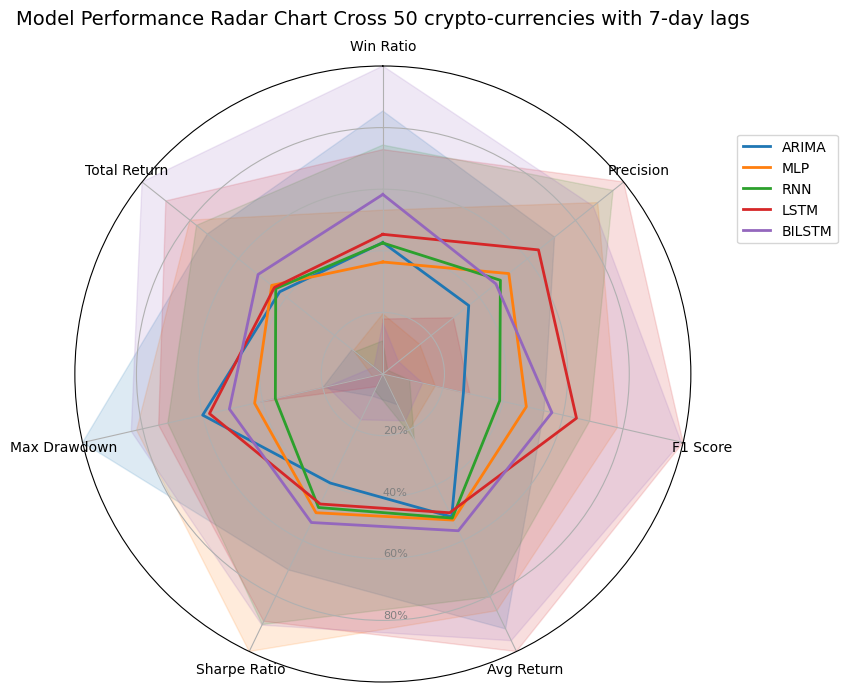

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 读取并预处理数据
df = pd.read_csv(r'C:\Users\Fisher Man\OneDrive\Desktop\Work Sheet\Py\Some Projects\Comput_Fin\Project\Book1.csv')
df = df.groupby(['model']).agg(
    WinRatio_mean=('Win Ratio', 'mean'),
    WinRatio_var=('Win Ratio', 'var'),
    Precision_mean=('Precision', 'mean'),
    Precision_var=('Precision', 'var'),
    F1_Score_mean=('F1 Score', 'mean'),
    F1_Score_var=('F1 Score', 'var'),
    Avg_Return_mean=('Avg Return', 'mean'),
    Avg_Return_var=('Avg Return', 'var'),
    Sharpe_Ratio_mean=('Sharpe Ratio', 'mean'),
    Sharpe_Ratio_var=('Sharpe Ratio', 'var'),
    Max_Drawdown_mean=('Max Drawdown', 'mean'),
    Max_Drawdown_var=('Max Drawdown', 'var'),
    Total_Return_mean=('Total Return', 'mean'),
    Total_Return_var=('Total Return', 'var')
).reset_index()

# 配置模型和指标
models = ['ARIMA', 'MLP', 'RNN', 'LSTM', 'BILSTM']
metrics = ['Win Ratio', 'Precision', 'F1 Score', 'Avg Return',
          'Sharpe Ratio', 'Max Drawdown', 'Total Return']
colors = ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD']

# 构建数据映射关系
metric_columns = {
    'Win Ratio': ('WinRatio_mean', 'WinRatio_var'),
    'Precision': ('Precision_mean', 'Precision_var'),
    'F1 Score': ('F1_Score_mean', 'F1_Score_var'),
    'Avg Return': ('Avg_Return_mean', 'Avg_Return_var'),
    'Sharpe Ratio': ('Sharpe_Ratio_mean', 'Sharpe_Ratio_var'),
    'Max Drawdown': ('Max_Drawdown_mean', 'Max_Drawdown_var'),
    'Total Return': ('Total_Return_mean', 'Total_Return_var')
}

# 从DataFrame提取数据
mean_data = {model: [] for model in models}
std_data = {model: [] for model in models}

for model in models:
    model_data = df[df['model'] == model]
    for metric in metrics:
        mean_col, var_col = metric_columns[metric]
        mean_val = model_data[mean_col].values[0]
        std_val = np.sqrt(model_data[var_col].values[0])  # 方差转标准差
        mean_data[model].append(mean_val)
        std_data[model].append(std_val)

# 数据归一化处理
normalized = {}
for model in models:
    normalized[model] = {'mean': [], 'upper': [], 'lower': []}
    for i, metric in enumerate(metrics):
        raw_mean = mean_data[model][i]
        raw_std = std_data[model][i]
        
        # 计算指标全局范围
        all_vals = [mean_data[m][i] + std_data[m][i] for m in models] + \
                  [mean_data[m][i] - std_data[m][i] for m in models]
        min_val, max_val = min(all_vals), max(all_vals)
        
        # 执行归一化
        normalized_mean = (raw_mean - min_val) / (max_val - min_val)
        normalized_upper = (raw_mean + raw_std - min_val) / (max_val - min_val)
        normalized_lower = (raw_mean - raw_std - min_val) / (max_val - min_val)
        
        normalized[model]['mean'].append(normalized_mean)
        normalized[model]['upper'].append(normalized_upper)
        normalized[model]['lower'].append(normalized_lower)

# 创建雷达图
plt.figure(figsize=(10, 8))
ax = plt.subplot(111, polar=True)

# 设置极坐标角度
angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]

# 绘制每个模型
for idx, model in enumerate(models):
    # 准备环形数据
    mean = normalized[model]['mean'] + [normalized[model]['mean'][0]]
    upper = normalized[model]['upper'] + [normalized[model]['upper'][0]]
    lower = normalized[model]['lower'] + [normalized[model]['lower'][0]]
    
    # 绘制置信区间
    ax.fill(angles, upper, angles, lower, color=colors[idx], alpha=0.15)
    # 绘制均值线
    ax.plot(angles, mean, color=colors[idx], linewidth=2, label=model)

# 美化图表
ax.set_theta_offset(np.pi/2)
ax.set_theta_direction(-1)
ax.set_rlabel_position(180)
plt.xticks(angles[:-1], metrics, fontsize=10)
plt.ylim(0, 1)
plt.yticks([0.2, 0.4, 0.6, 0.8], ["20%", "40%", "60%", "80%"], color="grey", fontsize=8)
plt.title("Model Performance Radar Chart Cross 50 crypto-currencies with 7-day lags", pad=30, fontsize=14)

# 添加图例
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 0.9))
plt.savefig('radar_chart.png', dpi = 300)
plt.show()
